In [1]:
# Import the necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, mean_squared_log_error
from tensorflow.keras.layers import Dense, Flatten, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dropout, SpatialDropout1D
from tensorflow.keras.layers import Layer, RepeatVector, concatenate, Reshape, Input, Concatenate, Permute, Multiply, Add, Activation

In [2]:
# Load data
df = pd.read_csv('CTLT.csv')
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-01-02,30.860001,31.260000,30.240000,30.910000,30.910000,1201700
1,2019-01-03,30.660000,30.660000,29.290001,29.840000,29.840000,1149900
2,2019-01-04,30.049999,31.360001,29.940001,31.080000,31.080000,3530400
3,2019-01-07,31.020000,32.180000,30.850000,32.000000,32.000000,1063400
4,2019-01-08,32.340000,33.060001,32.150002,32.790001,32.790001,1391000
...,...,...,...,...,...,...,...
1079,2023-04-17,46.009998,49.860001,42.529999,45.430000,45.430000,14629300
1080,2023-04-18,45.200001,45.375000,41.509998,42.080002,42.080002,10057000
1081,2023-04-19,41.419998,43.669998,41.330002,43.070000,43.070000,6744900
1082,2023-04-20,42.660000,44.410000,42.259998,44.400002,44.400002,3464300


In [3]:
# Convert the 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Set the 'Date' column as the index value
df.set_index('Date', inplace=True)

In [4]:
# Show DataFrame
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-01-02,30.860001,31.260000,30.240000,30.910000,30.910000,1201700
2019-01-03,30.660000,30.660000,29.290001,29.840000,29.840000,1149900
2019-01-04,30.049999,31.360001,29.940001,31.080000,31.080000,3530400
2019-01-07,31.020000,32.180000,30.850000,32.000000,32.000000,1063400
2019-01-08,32.340000,33.060001,32.150002,32.790001,32.790001,1391000
...,...,...,...,...,...,...
2023-04-17,46.009998,49.860001,42.529999,45.430000,45.430000,14629300
2023-04-18,45.200001,45.375000,41.509998,42.080002,42.080002,10057000
2023-04-19,41.419998,43.669998,41.330002,43.070000,43.070000,6744900


In [5]:
# Descriptive Statistical
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,1084.000000,1084.000000,1084.000000,1084.000000,1084.000000,1.084000e+03
mean,81.386891,82.582040,80.080622,81.360083,81.360083,1.316687e+06
std,29.623591,29.926995,29.218822,29.553762,29.553762,1.607532e+06
min,30.049999,30.660000,29.290001,29.840000,29.840000,2.197000e+05
25%,52.202500,53.042000,51.707500,52.247501,52.247501,7.046750e+05
50%,83.495002,84.510002,82.259998,83.505001,83.505001,9.811000e+05
75%,106.260000,108.073750,104.765001,106.450002,106.450002,1.423700e+06
max,142.639999,142.639999,140.779999,142.350006,142.350006,3.083880e+07


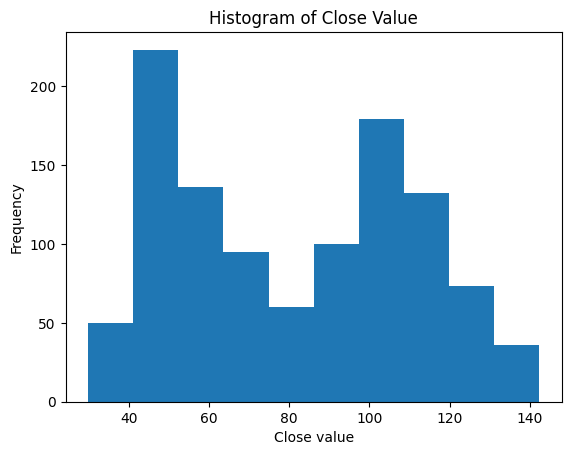

In [6]:
#  Draw a histogram
plt.hist(df['Close'])

# Set label and title
plt.xlabel('Close value')
plt.ylabel('Frequency')
plt.title('Histogram of Close Value')

# Display histogram
plt.show()

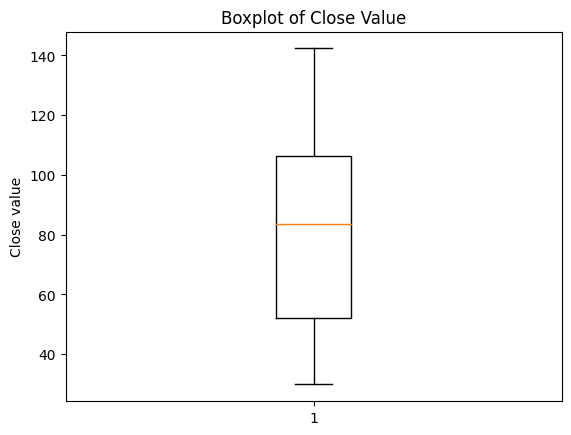

In [7]:
# Draw a boxplot
plt.boxplot(df.Close)

# Set label and title
plt.title("Boxplot of Close Value")
plt.ylabel("Close value")

# Hiển thị biểu đồ
plt.show()

In [8]:
# Select column 'Close'
data = df['Close'].values

In [9]:
# Standardized data
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data.reshape(-1, 1))

In [10]:
# Split the data into train, validate, and test sets in a ratio of 7:2:1
train_size = int(len(data_scaled) * 0.7)
val_size = int(len(data_scaled) * 0.2)
test_size = len(data_scaled) - train_size - val_size

train_data = data_scaled[0 : train_size, :]
val_data = data_scaled[train_size : train_size + val_size, :]
test_data = data_scaled[train_size + val_size : len(data_scaled), :]

In [11]:
# Create sequences
def prepare_sequences(data, sequence_length):
    sequences, targets = [], []
    for i in range(len(data) - sequence_length - 1):
        sequences.append(data[i : (i + sequence_length), :])
        targets.append(data[i + sequence_length, 0])
    return np.array(sequences), np.array(targets)

In [12]:
sequence_length = 30
train_sequences, train_targets = prepare_sequences(train_data, sequence_length)
test_sequences, test_targets = prepare_sequences(test_data, sequence_length)
val_sequences, val_targets = prepare_sequences(val_data, sequence_length)

In [13]:
class AttentionLayer(Layer):
    def __init__(self, attention_dim):
        super(AttentionLayer, self).__init__()
        self.attention_dim = attention_dim

    def build(self, input_shape):
        self.W1 = Dense(units=self.attention_dim, activation='tanh')
        self.W2 = Dense(units=1, activation='linear')
        super(AttentionLayer, self).build(input_shape)

    def call(self, x):
        score = self.W2(self.W1(x))
        score = Flatten()(score)
        score = Activation('softmax')(score)
        score = RepeatVector(x.shape[-1])(score)
        score = Permute([2, 1])(score)
        return Multiply()([x, score])

    def compute_output_shape(self, input_shape):
        return input_shape

In [14]:
# Build TCAN model
def build_tcan(sequence_length, input_dim=1, tcn_filters=64, tcn_kernel_size=2, dropout_rate=0.2, attention_dim=16):
    inputs = Input(shape=(sequence_length, input_dim))
    x = inputs
    x = Conv1D(filters=tcn_filters, kernel_size=tcn_kernel_size, padding='same', activation='relu')(x)
    x = SpatialDropout1D(rate=dropout_rate)(x)
    x = Conv1D(filters=tcn_filters, kernel_size=tcn_kernel_size, padding='same', activation='relu')(x)
    x = SpatialDropout1D(rate=dropout_rate)(x)

    # Additive Attention
    att = AttentionLayer(attention_dim)(x)
    max_pool_att = GlobalMaxPooling1D()(att)
    max_pool_x = GlobalMaxPooling1D()(x)
    x = concatenate([max_pool_att, max_pool_x])

    outputs = Dense(1)(x)

    model = Model(inputs=inputs, outputs=outputs)
    optimizer = Adam(learning_rate=0.001)
    model.compile(loss='mean_absolute_error', optimizer=optimizer)

    return model

In [15]:
# Model building
model = build_tcan(sequence_length)
early_stop = EarlyStopping(monitor='val_loss', patience=5)
# Model training
history = model.fit(train_sequences, train_targets, epochs=50, batch_size=32, validation_data=(val_sequences, val_targets), 
                    shuffle=False, callbacks=[early_stop], verbose=1)

Epoch 1/50
23/23 [==============================] - 4s 33ms/step - loss: 0.1275 - val_loss: 0.1527
Epoch 2/50
23/23 [==============================] - 0s 13ms/step - loss: 0.1165 - val_loss: 0.0809
Epoch 3/50
23/23 [==============================] - 0s 9ms/step - loss: 0.0881 - val_loss: 0.0744
Epoch 4/50
23/23 [==============================] - 0s 9ms/step - loss: 0.0666 - val_loss: 0.0705
Epoch 5/50
23/23 [==============================] - 0s 9ms/step - loss: 0.0639 - val_loss: 0.0666
Epoch 6/50
23/23 [==============================] - 0s 9ms/step - loss: 0.0596 - val_loss: 0.0587
Epoch 7/50
23/23 [==============================] - 0s 9ms/step - loss: 0.0574 - val_loss: 0.0554
Epoch 8/50
23/23 [==============================] - 0s 9ms/step - loss: 0.0530 - val_loss: 0.0531
Epoch 9/50
23/23 [==============================] - 0s 9ms/step - loss: 0.0540 - val_loss: 0.0483
Epoch 10/50
23/23 [==============================] - 0s 9ms/step - loss: 0.0471 - val_loss: 0.0432
Epoch 11/50
23/23

In [16]:
# Prediction on test set
y_pred = model.predict(test_sequences)

3/3 [==============================] - 0s 4ms/step


In [17]:
# Evaluate the accuracy of test
test_mae = mean_absolute_error(test_targets, y_pred)
test_mape = mean_absolute_percentage_error(test_targets, y_pred)
test_mse = mean_squared_error(test_targets, y_pred)
test_rmse = np.sqrt(test_mse)
test_msle = mean_squared_log_error(test_targets, y_pred)

print(f"MAE on Test set: ", test_mae)
print(f"MAPE on Test set: ", test_mape)
print(f"MSE on Test set: ", test_mse)
print(f"RMSE on Test set: ", test_rmse)
print(f"MSLE on Test set: ", test_msle)

MAE on Test set:  0.025968194920524216
MAPE on Test set:  0.14595307507687535
MSE on Test set:  0.0018509021067895535
RMSE on Test set:  0.04302211183553817
MSLE on Test set:  0.0012527336260084862


In [18]:
# Get the last date from the current index
last_date = df.index[-1]

# Add one day to the last date
next_date = last_date + pd.DateOffset(days=1)

# Create a list of indices starting from the next date for 30 days
index_next_30_days = pd.date_range(start=next_date, periods=30).tolist()

# Predict the closing price for the next 30 days
last_sequence_days = data[-sequence_length:].reshape(1, -1, 1)
y_next_30_days = []

for i in range(30):
    # Predict the next day's closing price
    next_day_pred = model.predict(last_sequence_days)
    
    # Save prediction
    y_next_30_days.append(next_day_pred[0][0])
    
    # Update data for the next day
    last_sequence_days = np.concatenate([last_sequence_days[:, 1:, :], next_day_pred.reshape(1, 1, 1)], axis=1)

1/1 [==============================] - 0s 22ms/step


In [19]:
len(scaler.inverse_transform(val_data))

216

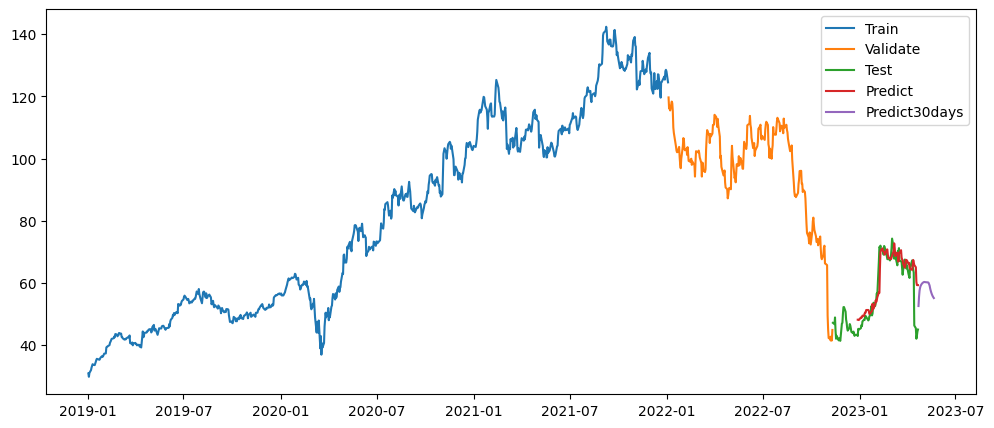

In [20]:
# Visualization
plt.figure(figsize=(12, 5))

plt.plot(df.index[:train_size], scaler.inverse_transform(train_data))

plt.plot(df.index[train_size : train_size + val_size], scaler.inverse_transform(val_data))

plt.plot(df.index[train_size + val_size : ], scaler.inverse_transform(test_data))

plt.plot(df.index[train_size + val_size + sequence_length + 1: ],scaler.inverse_transform(y_pred))

plt.plot(index_next_30_days, y_next_30_days)

plt.legend(['Train', 'Validate', 'Test', 'Predict', 'Predict30days'])
plt.show()